# Introduction

This notebook will be focused on two approaches of Bayesian inference: **Naive Bayesian Classifier** and the **Bayesian Linear Regressor**. Both of them will be implemented from scratch and tested on two well known dataset: **MNIST** and **CIFAR10**.

In [2]:
#%load_ext line_profiler
import warnings
import itertools
import scipy

import numpy             as np
import tensorflow        as tf
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
#import progressbar as pb
import numpy.linalg

from IPython.display       import set_matplotlib_formats
from keras.datasets        import cifar10, mnist
from sklearn.metrics       import accuracy_score, confusion_matrix, mean_squared_error, log_loss
from pprint                import pprint
from numpy.linalg          import inv, det
from time                  import time
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"


Using TensorFlow backend.


## The MNIST and CIFAR10 datasets

Let's start by downloading and importing the two datasets. Since these are two famous datasets, some Python modules (in this case `Keras`) already provide support for handling training and testing.

In [127]:
(mnist_image_train, mnist_label_train), (mnist_image_test, mnist_label_test) = mnist.load_data()
print('MNIST dataset correctly downloaded and imported.', end='\n\n')

(cifar10_image_train, cifar10_label_train), (cifar10_image_test, cifar10_label_test) = cifar10.load_data()
print('CIFAR10 dataset correctly downloaded and imported.')

MNIST dataset correctly downloaded and imported.

CIFAR10 dataset correctly downloaded and imported.


## Dataset analysis

Let's look at some numbers: first of all let's comment on the dimensionality of the input.

In [4]:
print('Number of training samples for MNIST: %s' % str(len(mnist_image_train)))
print('Number of testing samples for MNIST : %s' % str(len(mnist_image_test)))
print('The shape of a MNIST sample is %s' % str(mnist_image_train[3].shape), end='\n\n')

print('Number of training samples for CIFAR10: %s' % str(len(cifar10_image_train)))
print('Number of testing samples for CIFAR10 : %s' % str(len(cifar10_image_test)))
print('Shape of a CIFAR10 sample is %s' % str(cifar10_image_train[3].shape))

Number of training samples for MNIST: 60000
Number of testing samples for MNIST : 10000
The shape of a MNIST sample is (28, 28)

Number of training samples for CIFAR10: 50000
Number of testing samples for CIFAR10 : 10000
Shape of a CIFAR10 sample is (32, 32, 3)


Each sample in MNIST is a $28 \times 28$ B&W image and therefore it has a dimensionality of $784$ features; on the other hand, CIFAR is a collection of bigger colored images and, in particular, each sample has $3072$ features: this is a huge difference with respect to MNIST, and since the number of training samples is even less, we will expect a great difference in the performances between MNIST and CIFAR. Let's now have a look on how many labels there are and how they are distributed.

In [5]:
print('Possible labels for MNIST: %s' % list(set(mnist_label_train)))
print('Possible labels for CIFAR: %s' % list(set(np.array(cifar10_label_train)[:,0])))

Possible labels for MNIST: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Possible labels for CIFAR: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Both of them has 10 possible classes but since MNIST is database of handwritten digits, there's immediately a correspondence between the numerical label and the description. For CIFAR, though, the possible descriptive labels are the following.

In [6]:
labels = [ 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Possible descriptive labels for CIFAR: \n%60s\n%52s' % (labels[:5], labels[5:]))

Possible descriptive labels for CIFAR: 
           ['airplane', 'automobile', 'bird', 'cat', 'deer']
           ['dog', 'frog', 'horse', 'ship', 'truck']


Let's look at the distribution of labels in the two training datasets

In [7]:
unique, counts = np.unique(mnist_label_train, return_counts=True)
_, counts2 = np.unique(cifar10_label_train, return_counts=True)
print('%17s %8s' % ('MNIST', 'CIFAR'))
_ = [print('Label %s:%5s%d%5s%d' % (u,' ', c,' ', c2)) for u, c, c2 in zip(unique, counts, counts2)]

            MNIST    CIFAR
Label 0:     5923     5000
Label 1:     6742     5000
Label 2:     5958     5000
Label 3:     6131     5000
Label 4:     5842     5000
Label 5:     5421     5000
Label 6:     5918     5000
Label 7:     6265     5000
Label 8:     5851     5000
Label 9:     5949     5000


It's interesting to notice that MNIST labels are not uniformly distributed; nevertheless, since the difference is not so big, for the sake of simplicity for both MNIST and CIFAR all labels will be treated as equally probable.

Let's show some pictures to better understand the problem we're working with.

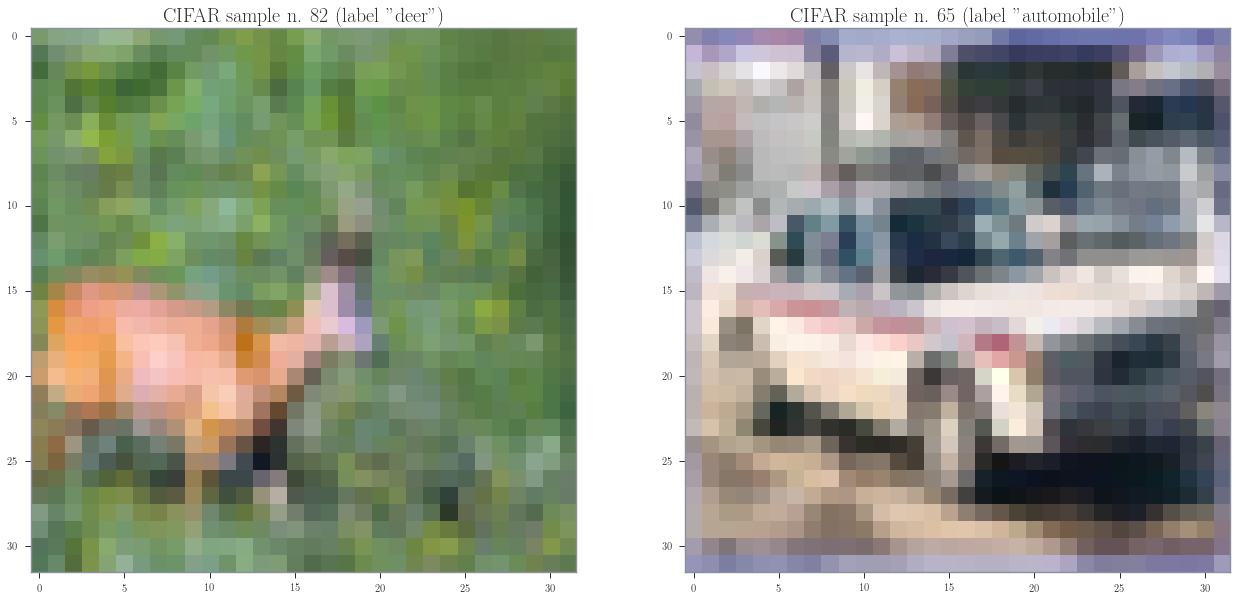

In [71]:
labels = [ 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig = plt.figure(figsize=[21.5, 10])
ax = fig.add_subplot(1, 2, 1)
ax.set_xlim(0, 32)
ax.set_ylim(0, 32)
i = np.random.randint(0, 100)
ax.imshow(cifar10_image_train[i])
plt.title('CIFAR sample n. %s (label "%s")' % (i, labels[cifar10_label_train[i][0]]))
ax = fig.add_subplot(1, 2, 2, sharex=ax, sharey=ax)
i = np.random.randint(0, 100)
ax.imshow(cifar10_image_train[i])
plt.title('CIFAR sample n. %s (label "%s")' % (i, labels[cifar10_label_train[i][0]]))
plt.show()

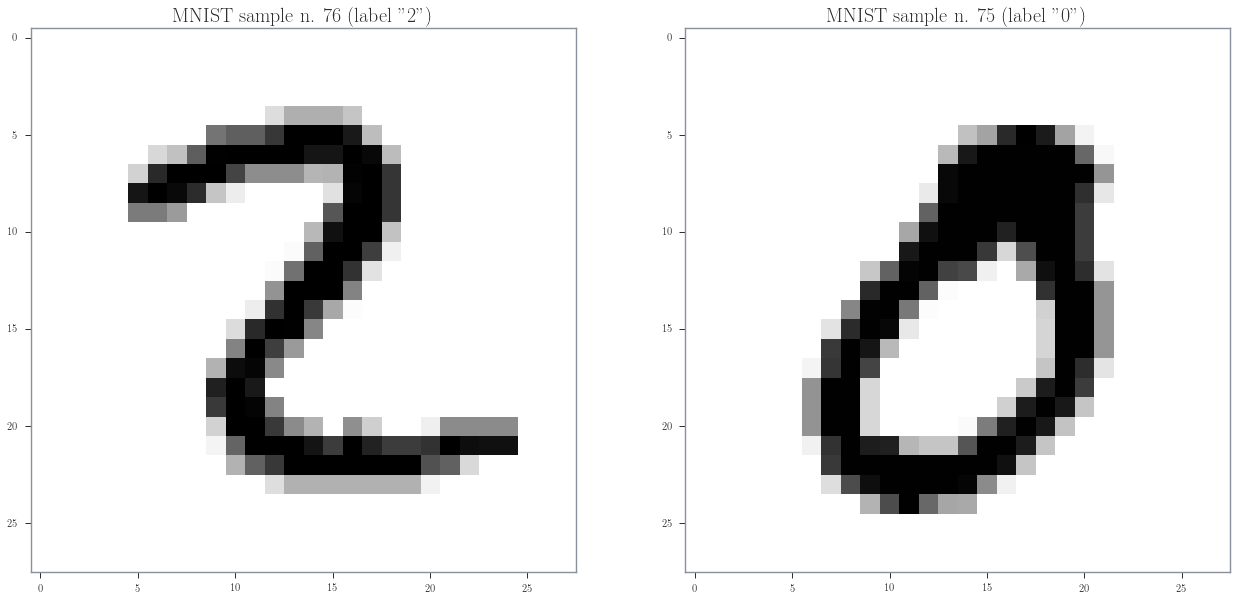

In [72]:
fig = plt.figure(figsize=[21.5, 10])
ax = fig.add_subplot(1, 2, 1)
ax.set_xlim(0, 32)
ax.set_ylim(0, 32)
i = np.random.randint(0, 100)
ax.imshow(mnist_image_train[i], cmap=plt.cm.binary)
plt.title('MNIST sample n. %s (label "%s")' % (i, mnist_label_train[i]))
ax = fig.add_subplot(1, 2, 2, sharex=ax, sharey=ax)
i = np.random.randint(0, 100)
ax.imshow(mnist_image_train[i], cmap=plt.cm.binary)
plt.title('MNIST sample n. %s (label "%s")' % (i, mnist_label_train[i]))
plt.show()

# Naive Bayes Classifier

Without describing in details how the **Naive Bayes Classifier** works, here we just present some useful identities and equation for the implementation. Let's start by looking at the Bayes rule.

\begin{equation}
P(t_{new}=k | \mathbf{X}, \mathbf{t}, \mathbf{x_{new}}) = 
    \dfrac{P(\mathbf{x_{new}} | t_{new}=k, \mathbf{X}, \mathbf{t})P(t_{new}=k)}
          {\sum_{j=0}^{K-1} P(\mathbf{x_{new}} | t_{new}=j, \mathbf{X}, \mathbf{t})P(t_{new}=j) }
\end{equation}

In our case, we set a **Uniform Prior** and a **Gaussian Likelihood** whose parameters are obtained as follows.

\begin{equation}
P(\mathbf{x} | t=k, \mathbf{X}, \mathbf{t}) = \prod_{d=0}^{D-1} \mathcal{N}(\mu_{kd}, \sigma_{kd})
\end{equation}

where $\mu_{kd}=\dfrac{1}{N_k}\sum_{n:t_n=k}x_{nd}$ and  $\sigma_{kd}=\dfrac{1}{N_k}\sum_{n:t_n=k}(x_{nd}-\mu_{nd})^2$

For better numerical stability, also the approximated **Gaussian LogLikelihood** has been defined and implemented as follows:

\begin{equation}
\log P(\mathbf{x} | t=k, \mathbf{X}, \mathbf{t}) = \sum_{d=0}^{D-1}\log \mathcal{N}(\mu_{kd}, \sigma_{kd})
\end{equation}

Taking advantage of the Jensen's Inequality, the label prediction of a samples reduces as follows

\begin{equation}
t_{new} = argmax_{k}\left \{ \log P(\mathbf{x} | t=k, \mathbf{X}, \mathbf{t}) + \log P(t=k) - \sum_{j=0}^{K-1} \log P(\mathbf{x} | t=j, \mathbf{X}, \mathbf{t})\right \}
\end{equation}



## Implementation of the Naïve Bayes classifier

To avoid filling the report with pages of code, the implementation can be viewed on the HTML version of the notebook. The important remark is that all the possible computations are done in matrix form taking advantage of the `C`-like performance of Numpy.

In [19]:
def fromImagesToFeatures(images):
    images = np.asarray(images, dtype=np.float64)
    x = np.reshape(images, (images.shape[0], -1))
    x /= x.max() 
    return x

def prior(num_classes, label=None):
    return 1/num_classes

def likelihood(x_new, k, means, variances):
    def normal(x, mu, sigma2):
        return 1 / (np.sqrt(2*np.pi*sigma2)) * np.exp(-((x-mu)**2)/(2*sigma2))
    likelihood = np.float128(1.)
    
    likelihood = np.prod(normal(x_new, means[k], variances[k]), dtype=np.float128)
    return likelihood

def loglikelihood(x_new, k, means, variances):
    def lognormal(x, mu, sigma2):
        return np.log(1 / (np.sqrt(2*np.pi*sigma2))) + (-((x-mu)**2)/(2*sigma2))
    likelihood = np.float128(1.)
    
    loglikelihood = np.sum(lognormal(x_new, means[k], variances[k]), dtype=np.float128)
    #print(loglikelihood)
    return loglikelihood
    
def trainBayesianClassifier(images, labels):
    def fitBayesianClassifier(x, eps=1e-5):
        mu_d = np.mean(x, axis=0)#(np.sum(x, axis=0)+1)/x.shape[0]
        sigma2_d = np.var(x, axis=0) + eps
        return (mu_d, sigma2_d)
    t0 = time()
    data_df = pd.DataFrame(fromImagesToFeatures(images))
    data_df['label'] = labels
    means = []
    variances = []
    #print(data_df)
    for i in range(np.max(labels)+1):
        mu_k, sigma_k = fitBayesianClassifier(data_df[data_df['label']==i].drop('label', axis=1).values)
        means.append(mu_k)
        variances.append(sigma_k)
    print('Training completed in %.2f seconds.' % (time()-t0))
    return (np.array(means), np.array(variances))

       
def predictBayesianClassifier(images_test, means, variances, n_classes, i=None, debug=True):
    #for x_new in fromImagesToFeatures(images):
    list_of_predictions = []
    testset = fromImagesToFeatures(images_test)[:i] if i != None else fromImagesToFeatures(images_test)

    bar = pb.ProgressBar(widgets=[ pb.Percentage(),  pb.Bar(), pb.AdaptiveETA() ], max_value=len(testset)).start() \
          if not debug else 0
    for i, x_new in enumerate(testset): 
        marginal_likelihood = .0
        for k in range(means.shape[0]):
            marginal_likelihood += prior(n_classes)*likelihood(x_new, k, means, variances)
        probabilities = []
        for k in range(means.shape[0]):       
            p = likelihood(x_new, k, means, variances)*prior(n_classes)
            probabilities.append(p/marginal_likelihood)
            print('k = ' + str(k) + ' : ' + str(p/marginal_likelihood)) if debug else 0
            #print(p, marginal_likelihood)
        print() if debug else 0
        list_of_predictions.append(probabilities)
        bar.update(i)
    bar.finish()
    return list_of_predictions

def predictLogBayesianClassifier(images_test, means, variances, n_classes, i=None, debug=True):
    #for x_new in fromImagesToFeatures(images):
    list_of_predictions = []
    testset = fromImagesToFeatures(images_test)[:i] if i != None else fromImagesToFeatures(images_test)

    bar = pb.ProgressBar(widgets=[ pb.Percentage(),  pb.Bar(), pb.AdaptiveETA() ], max_value=len(testset)).start() \
          if not debug else 0
    for x_new in testset:  
        marginal_loglikelihood = .0
        for k in range(means.shape[0]):
            marginal_loglikelihood += np.log(prior(n_classes)) + loglikelihood(x_new, k, means, variances)
        probabilities = []
        #print(marginal_loglikelihood)
        for k in range(means.shape[0]):       
            posterior = loglikelihood(x_new, k, means, variances) + np.log(prior(n_classes))# - marginal_loglikelihood
            #print(posterior)
            posterior = (posterior - marginal_loglikelihood)
            #print(posterior)
            probabilities.append(posterior)
            print('k = ' + str(k) + ' : ' + str(posterior)) if debug else 0
            #print(p, marginal_likelihood)
        print() if debug else 0
        list_of_predictions.append(probabilities)
        bar += 2
    bar.finish() if not debug else 0
    return list_of_predictions

Let's run the training and the predictions with few images, just to prove the correctness of this implementation.

In [9]:
means, variances = trainBayesianClassifier(mnist_image_train, mnist_label_train)

Training completed in 1.10 seconds.


In [10]:
result = predictLogBayesianClassifier(mnist_image_test, means, variances, 10, 2)

k = 0 : 345729.851221
k = 1 : 362996.976449
k = 2 : 343982.455369
k = 3 : 439455.35421
k = 4 : 439927.686773
k = 5 : 440354.172781
k = 6 : 262095.888977
k = 7 : 441194.107172
k = 8 : 439030.597706
k = 9 : 441133.748314

k = 0 : 642525.431998
k = 1 : 654336.234654
k = 2 : 666777.161808
k = 3 : 589085.642204
k = 4 : 641678.075029
k = 5 : 662105.351307
k = 6 : 661814.741789
k = 7 : 386607.822711
k = 8 : 635668.013868
k = 9 : 450131.715342



The predictions are, respectively, 7 and 2. Let's see which are the true labels.

In [11]:
print('True labels: %s' % mnist_label_test[:2])

True labels: [7 2]


This is encouraging. Afterward we will run training and prediction on the whole dataset for both MNIST and CIFAR.

## Strengths and weaknesses of the Bayesian Classifier

The naive Bayes assumption is helpful when the dimensionality D of the input space is high, making density estimation in the full D-dimensional space more challenging. Another strength of this classifier is its non-parametric nature: training and prediction are done without writing down any equation that relates pixels to labels. 

On the other hand, though, to make it scalable we have done strong assumptions on the distribution of pixel values; for instance, to write the likelihood we made the approximation that each component of $\mathbf{x}$ is independent from the others: this is questionable. Intuitively, it's reasonable to assume that neighbors of a given pixel will share similar gray level and will not have significant differences. Nevertheless, this cross-correlation it's not taken into account.

##  Data  preprocessing

In this particular case, the first data preprocessing to be do is to flatten all the images: samples come in matrix form but they have to be converted into feature vectors. 

Secondly, since pixel ranges from 0 to 255, to guarantee better numerical stability (in particular to avoid overflows while computing intermediate results), it's better to normalize them all between 0 and 1. 

Finally, the dimensionality on the input space is much more than the required to distinguish ten classes. For instance, look at the next picture.

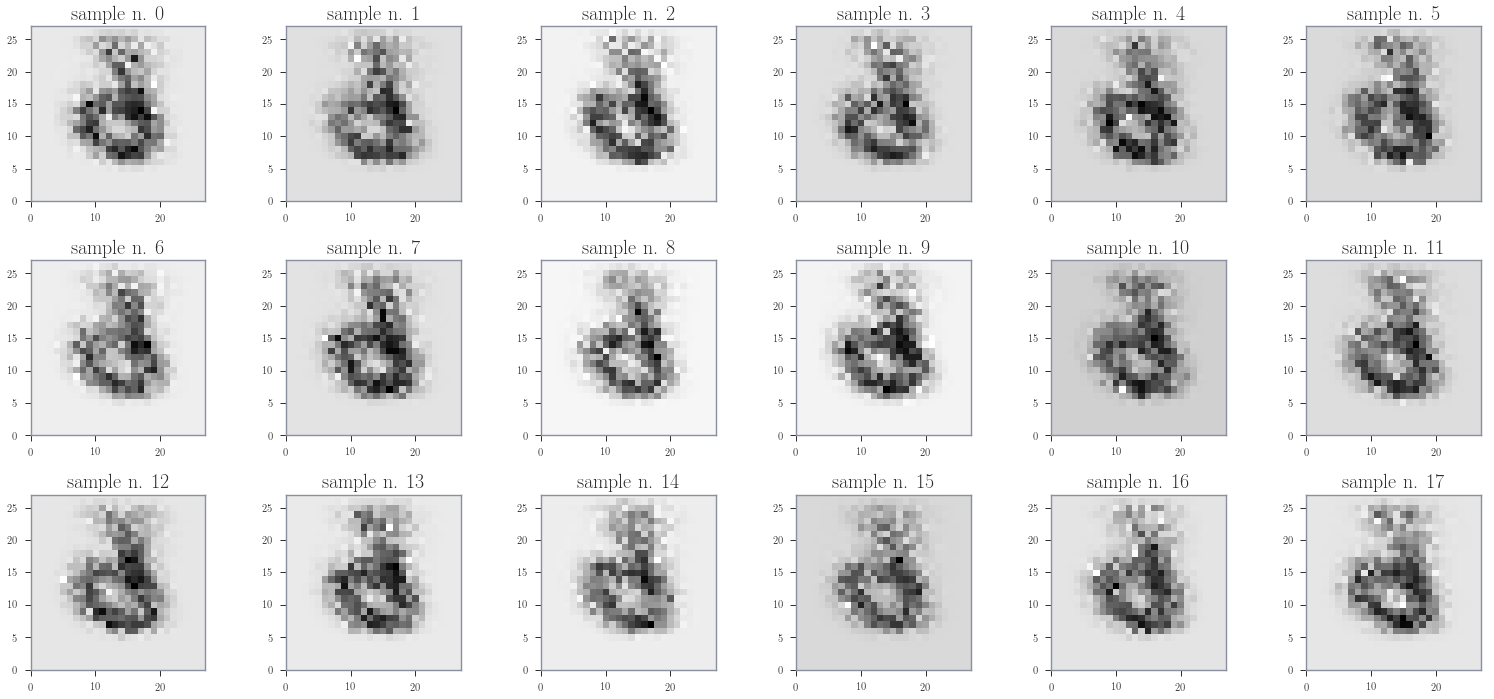

In [207]:
fig = plt.figure(figsize=[21.5, 10])
for i in range(18):
    img = np.random.normal(means[9], variances[9]).reshape(28, 28)
    ax = fig.add_subplot(3, 6, i+1)
    ax.set_xlim(0, 27)
    ax.set_ylim(0, 27)
    ax.imshow(img, cmap=plt.cm.binary)
    plt.title('sample n. %s' % (i))
    
plt.tight_layout()
plt.show()

These are 18 images coming from sampling a normal distribution with mean and variance of the digit `9`. As we can see, none of them is close to the original number; this suggest us that either the number of training samples is too low or the number of dimensions is too high. Since we cannot change the dataset, the only way to mitigate this effect is to reduce the dimensionality of the input. Therefore, a `PCA` or `KernelPCA` is strongly suggested to increase the performances.

Let's see how much the dimensionality can be reduced without losing too much information.

In [185]:
pca = PCA(n_components=784)
_ = mnist_image_train.reshape(-1, 784)
pca.fit(_)
X_kpca = pca.transform(_)
exvar = (pca.explained_variance_ratio_)
exvar.sort()
exvar = exvar[::-1]

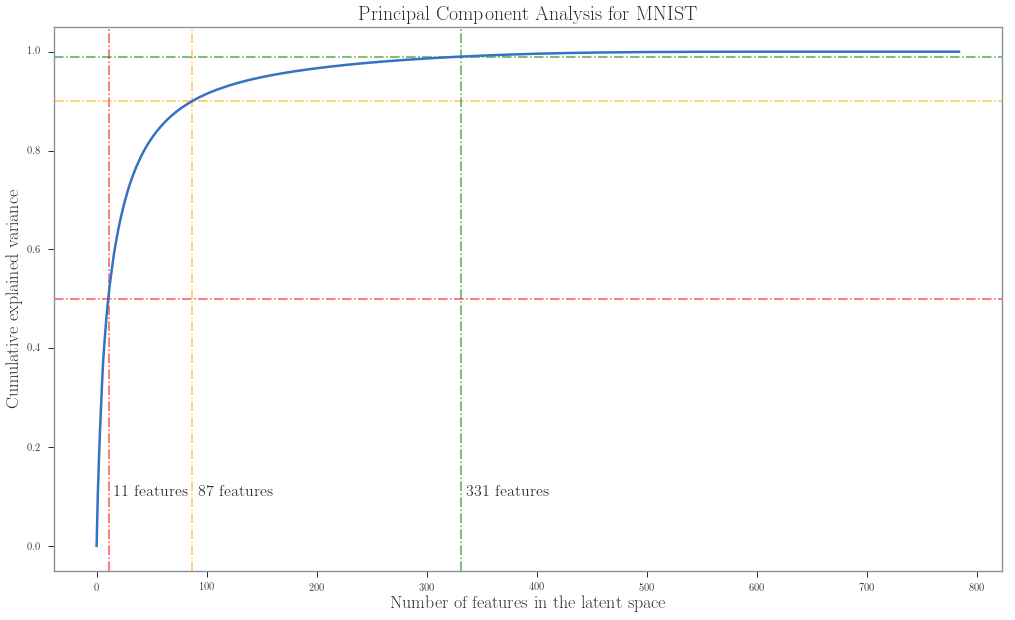

In [186]:
cdf = np.zeros_like(exvar)
for i in range(len(exvar)):
    cdf[i] = exvar[0] if i == 0 else cdf[i-1]+exvar[i]
cdf = np.insert(cdf, 0, 0) 

fig = plt.figure(figsize=[17, 10])
ax = plt.gca()
x = np.arange(0, 785)

f = np.where(cdf >= 0.5)[0][0]
ax.axhline(0.5, color='red', linestyle='-.', lw=2, alpha=0.5)
ax.axvline(f, linestyle='-.', color='red', lw=2, alpha=0.5,)
ax.text(f+5, 0.1, '%s features' % f)

f = np.where(cdf >= 0.9)[0][0]
ax.axhline(0.9, color='orange', linestyle='-.', lw=2, alpha=0.5)
ax.axvline(f,  linestyle='-.',color='orange', lw=2, alpha=0.5)
ax.text(f+5, 0.1, '%s features' % f)

f = np.where(cdf >= 0.99)[0][0]
ax.axhline(0.99, color='green', linestyle='-.',lw=2, alpha=0.5)
ax.axvline(f, linestyle='-.', color='green', lw=2, alpha=0.5)
ax.text(f+5, 0.1, '%s features' % f)

plt.plot(x, cdf, lw=2.5)

plt.xlabel('Number of features in the latent space')
plt.ylabel('Cumulative explained variance')
plt.title('Principal Component Analysis for MNIST')

plt.show()

This is really interesting. The analysis of the cumulative explained variance suggests that in order to maintain 50% of the information we need only 11 dimensions. The number increase to 87 for the 90% of information and to 331 for 99% of information. This means that if we accept to loose 1% of data we can reduce the number of feature to more than one half.

Let's do the same on the CIFAR and discuss the results.

In [187]:
pca = PCA(n_components=3072)
_ = cifar10_image_train.reshape(-1, 3072)
pca.fit(_)
X_kpca = pca.transform(_)
exvar = (pca.explained_variance_ratio_)
exvar.sort()
exvar = exvar[::-1]

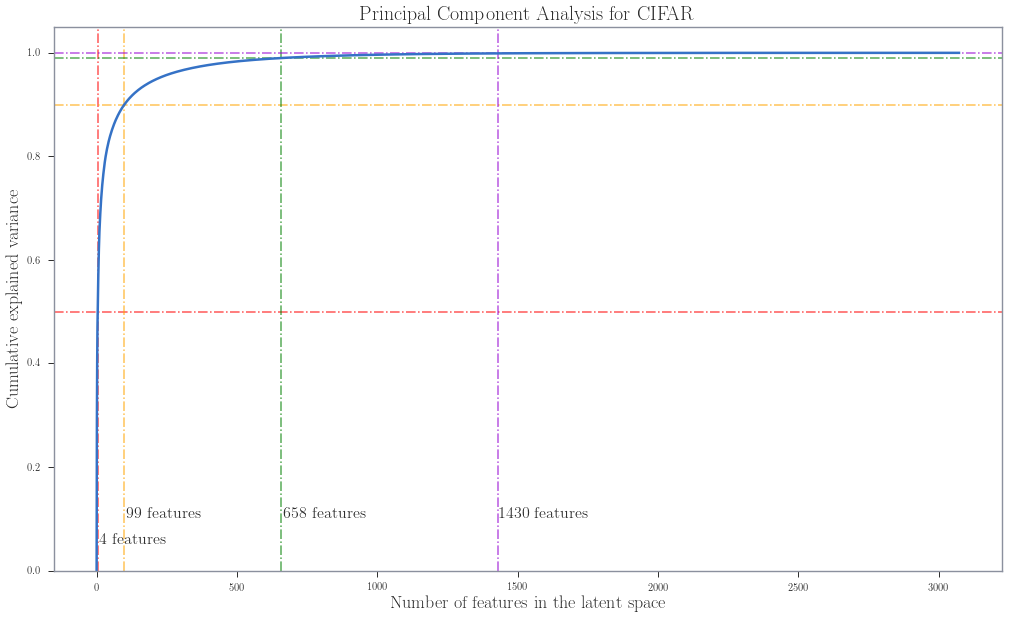

In [195]:
cdf = np.zeros_like(exvar)
for i in range(len(exvar)):
    cdf[i] = exvar[0] if i == 0 else cdf[i-1]+exvar[i]
    
cdf = np.insert(cdf, 0, 0)  
fig = plt.figure(figsize=[17, 10])
ax = plt.gca()
x = np.arange(0, 3073)

f = np.where(cdf >= 0.5)[0][0]
ax.axhline(0.5, color='red', linestyle='-.', lw=2, alpha=0.5)
ax.axvline(f, linestyle='-.', color='red', lw=2, alpha=0.5,)
ax.text(f+5, 0.05, '%s features' % f)

f = np.where(cdf >= 0.9)[0][0]
ax.axhline(0.9, color='orange', linestyle='-.', lw=2, alpha=0.5)
ax.axvline(f,  linestyle='-.',color='orange', lw=2, alpha=0.5)
ax.text(f+5, 0.1, '%s features' % f)

f = np.where(cdf >= 0.99)[0][0]
ax.axhline(0.99, color='green', linestyle='-.',lw=2, alpha=0.5)
ax.axvline(f, linestyle='-.', color='green', lw=2, alpha=0.5)
ax.text(f+5, 0.1, '%s features' % f)

f = np.where(cdf >= 0.999)[0][0]
ax.axhline(0.999, color='darkviolet', linestyle='-.',lw=2, alpha=0.5)
ax.axvline(f, linestyle='-.', color='darkviolet', lw=2, alpha=0.5)
ax.text(f+5, 0.1, '%s features' % f)


plt.plot(x, cdf, lw=2.5)

plt.xlabel('Number of features in the latent space')
plt.ylabel('Cumulative explained variance')
plt.title('Principal Component Analysis for CIFAR')
plt.ylim(0,)
plt.show()

Here the result are more impressive. For the 99% of information, only 658 features are needed. Even if the accuracy has to be 99.9%, the number of features can be more than halved. This is an huge saving.  

##  Performance Analysis

Let's train the classifier on both MNIST and CIFAR, without dimensionality reduction.

In [12]:
mnist_means, mnist_variances = trainBayesianClassifier(mnist_image_train, mnist_label_train)
cifar10_means, cifar10_variances = trainBayesianClassifier(cifar10_image_train, cifar10_label_train)

Training completed in 1.17 seconds.
Training completed in 4.30 seconds.


Let's run now the predictions.

In [21]:
print('Starting prediction...')
_ = [i for i in range(10000000)]
mnist_results = np.array(predictBayesianClassifier(mnist_image_test, mnist_means, mnist_variances, 10, debug=False))

Starting prediction...


100%|#######################################################################################################################################################################################|Time: 0:00:09


In [22]:
print('Starting prediction...')
_ = [i for i in range(10000000)]
cifar10_results = np.array(predictBayesianClassifier(cifar10_image_test, cifar10_means, cifar10_variances, 10, debug=False))

Starting prediction...


100%|#######################################################################################################################################################################################|Time: 0:00:18


In [23]:
mnist_predictions = np.array([np.argmax(result) for result in mnist_results])
cifar10_predictions = np.array([np.argmax(result) for result in cifar10_results])

Let's now look to some simple metric for performance evaluation. The first one is the accuracy score, which simply counts one many predictions were correct on the whole test set.

In [24]:
print('Accuracy for MNIST: %.4f' % accuracy_score(mnist_label_test, mnist_predictions))
print('Accuracy for CIFAR: %.4f' % accuracy_score(cifar10_label_test, cifar10_predictions))

Accuracy for MNIST: 0.6713
Accuracy for CIFAR: 0.2976


As expected accuracy is not so high and in particular our hypothesis on the high dimensionality of CIFAR was correct.

Let's see now the **loglikelihood** on the test data.

In [25]:
print('Log-Likelihood on test for MNIST: %.2f' % -log_loss(mnist_label_test, np.nan_to_num(mnist_results)))
print('Log-Likelihood on test for CIFAR: %.2f' % -log_loss(cifar10_label_test, np.nan_to_num(cifar10_results)))

Log-Likelihood on test for MNIST: -10.26
Log-Likelihood on test for CIFAR: -23.55


This is another figure of merit for analysing the performances of the classifier. In the contex of maximizing the likelihood, the Bayesian classifier for MNIST performs way better than for CIFAR. 

## Confusion Matrix

Let's now see the **confusion matrix** for both the datasets.

In [122]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.figure(figsize=[20, 15])

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = title + ' - normalized'

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f" % cm[i, j] if normalize else cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.title(title, fontsize=20)
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.show()

In [ ]:
mnist_cm = confusion_matrix(y_true=mnist_label_test, y_pred=mnist_predictions)
cifar10_cm = confusion_matrix(y_true=cifar10_label_test, y_pred=cifar10_predictions)

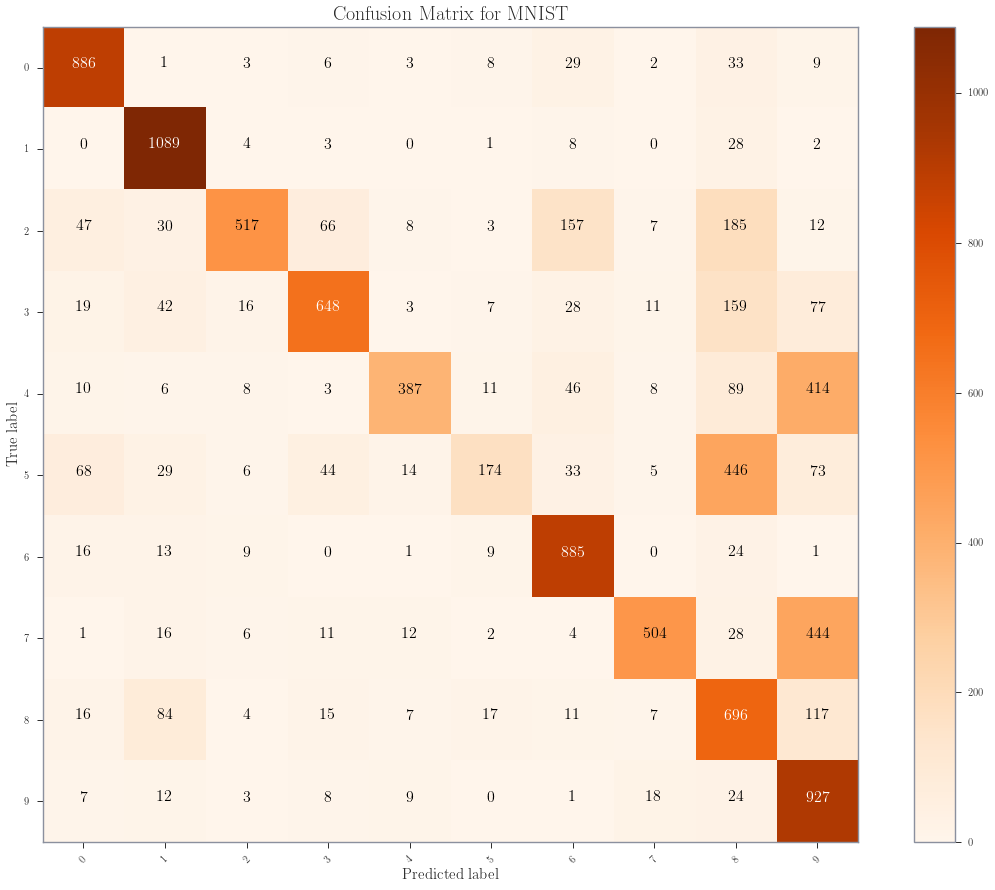

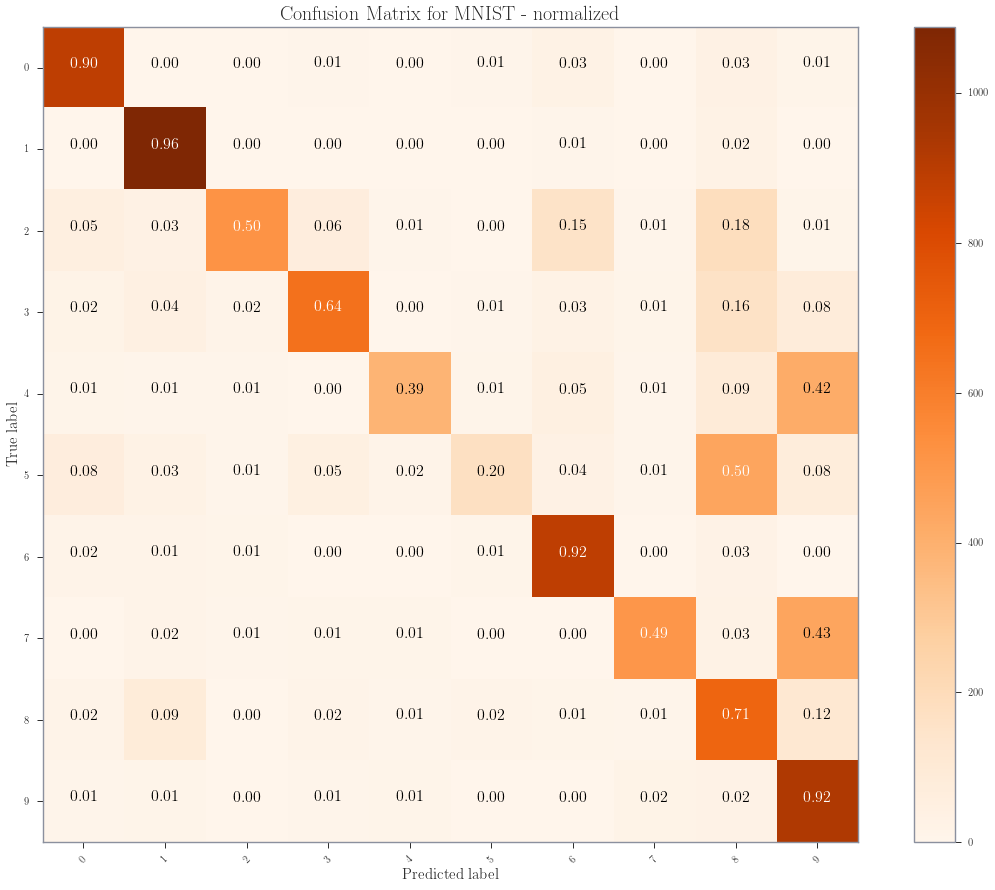

In [35]:
plot_confusion_matrix(mnist_cm, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], title='Confusion Matrix for MNIST')
plot_confusion_matrix(mnist_cm, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], title='Confusion Matrix for MNIST',  normalize=True)

From the analysis of this confusion matrix, we can notice some interesting trends. For instance, `0`, `1`, `6`, `8` and `9` are the best well-classified digits; on the other hand, though, due to similarity in the shapes, `4` and `5` are nearly never correctly labeled: `4` is most of the times confused with `9` and `5` with `8`. Finally, `2`, `3` and `7` are classified with the correct label about 50% of the times. 

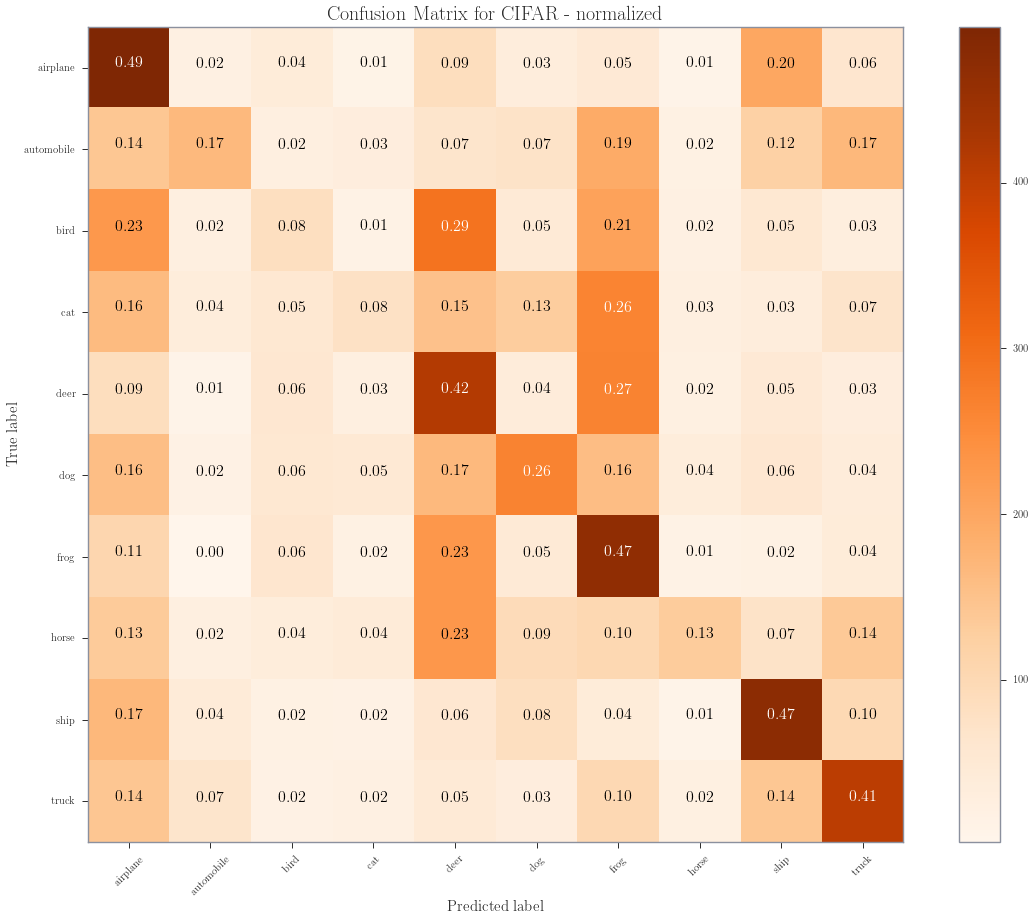

In [36]:
labels = [ 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(cifar10_cm, classes=labels, title='Confusion Matrix for CIFAR', normalize=True)

Here, the situation is much more tragic: almost all the classes are never correctly labeled and, even for the best one, more than half of the samples are missclassified. 

## Final discussion  on  performance

As said before, this simple classifier assumes independence between features (see Eq. 2). This underestimates the spacial information that each pixel carries on: as a consequence in order to increase the performance, the first thing to do is to break this assumption using, for instance, a **Multivariate Gaussian Likelihood**.

TODO: random features?

# Bayesian Linear Regression

## Implementation of Bayesian Linear Regression

Same as before, to avoid filling the report with pages of code, the implementation can be viewed on the HTML version of the notebook. The important remark is that all the possible computations are done in matrix form taking advantage of the C-like performance of Numpy.

In [51]:
def fromImagesToFeatures(images):
    images = np.array(images, dtype=np.float64)
    x = np.reshape(images, (images.shape[0], -1))
    x /= x.max() 
    return x

def computeDesignMatrix(samples, order):
    if order == 0:
        return np.ones_like(samples)
    return np.array([[(x_i)**k for k in range(0, order+1)] for x_i in samples]).reshape([samples.shape[0], -1])

def predictBayesianRegression(images, mu, sigma, sigma_n=1e-3, order=2):
    def normal(x, mu, sigma2):
        return 1 / (np.sqrt(2*np.pi*sigma2)) * np.exp(-((x-mu)**2)/(2*sigma2))
    
    def normalMultiVariate(x, mu, sigma):
        k = sigma.shape[0]
        print(x.shape)
        print(mu.shape)
        print(sigma.shape)
        return 1/((2*np.pi)**k * det(sigma)) * np.exp( ((x-mu)**2).T.dot(inv(sigma)).dot(x-mu))
    
    t0 = time()
    samples_new = fromImagesToFeatures(images)
    X_new = computeDesignMatrix(samples_new, order)
    post_mean = X_new.dot(mu)
    # post_mean ok
    #print(post_mean)
    post_cov = (sigma_n + X_new.dot(inv(sigma)).dot(X_new.T)).diagonal()
    #print(post_cov.diagonal())
    print('Predictions done in %.2f seconds.' % (time() - t0))
    return post_mean, post_cov
    #return normal(x_new, mu=post_mean, sigma2=post_cov)

def trainBayesianRegression(images, labels, sigma_n=1e-3, order=2):
    def computeSigma(X, S=None, sigma_n=1e-3):
        if S == None:
            S = np.zeros([X.shape[1], X.shape[1]])
            np.fill_diagonal(S, 1/np.random.random(X.shape[1]))
        return scipy.linalg.inv(1/sigma_n * X.T.dot(X)+S) #inv((1/sigma_n * X.T.dot(X)+inv(S)))
    
    def computeMu(X, t, Sigma, sigma_n=1e-3):
        return (1/sigma_n * Sigma.dot(X.T).dot(t))
    
    t0 = time()
    samples = fromImagesToFeatures(images)
    X = computeDesignMatrix(samples, order)
    #print(X.shape)

    Sigma = computeSigma(X, sigma_n = sigma_n)
    Mu = computeMu(X, labels, Sigma, sigma_n)
    print('Training completed in %.2f seconds.' % (time() - t0))
    return (Mu, Sigma)

def discretizeLabels(targets):
    def f(point):
        p = int(round(point))
        if p >= 9:
            return 9
        elif p <= 0:
            return 0
        return p
    t = list(map(lambda x:f(x), targets))
    return np.array(t)

## Treat class labels as continuous and apply regression to the training data.

Let's now train and predict on MNIST, for the moment with order 2.

In [103]:
mnist_post_mu, mnist_post_cov = trainBayesianRegression(mnist_image_train, mnist_label_train, sigma_n=1e-2, order=2)

Training completed in 18.29 seconds.


In [104]:
mnist_pred_mu, mnist_pred_var = predictBayesianRegression(mnist_image_test, mnist_post_mu, mnist_post_cov, sigma_n=1e-2, order=2)

Predictions done in 9.76 seconds.


And now on CIFAR.

In [55]:
cifar_post_mu, cifar_post_cov = trainBayesianRegression(cifar10_image_train, cifar10_label_train, 1e-2, order=2)

Training completed in 289.90 seconds.


In [57]:
cifar_pred_mu, cifar_pred_var = predictBayesianRegression(cifar10_image_test, cifar_post_mu, cifar_post_cov, 1e-2, order=2)

Predictions done in 109.33 seconds.


## Performance evaluations

Let's print some results, to see what we're dealing with.

In [105]:
print('[MNIST] True labels: %s' % mnist_label_test[:6])
print('[MNIST] Prediction means: %s' % mnist_pred_mu[:6])
print('[MNIST] Prediction variances: %s' % mnist_pred_var[:6], end='\n\n')
print('[CIFAR] True labels: %s' % cifar10_label_test[:6, 0])
print('[CIFAR] Prediction means: %s' % cifar_pred_mu[:6, 0])
print('[CIFAR] Prediction variances: %s' % cifar_pred_var[:6])

[MNIST] True labels: [7 2 1 0 4 1]
[MNIST] Prediction means: [ 6.450081    0.64458893  1.42564841  0.29986361  4.42983488  1.06002741]
[MNIST] Prediction variances: [  4.10881917e+12   4.23069922e+12   3.95048031e+12   4.60817195e+12
   4.09704850e+12   4.07852618e+12]

[CIFAR] True labels: [3 8 8 0 6 6]
[CIFAR] Prediction means: [ 6.79095726  5.22138838  5.17702008  3.57761586  3.59241034  4.92513226]
[CIFAR] Prediction variances: [  7.52807739e+13   9.83727712e+13   8.71292093e+13   9.49717453e+13
   7.45579247e+13   7.23116968e+13]


We can already appreciate some problems here: even though the prediction means  for MNIST are not far away from the true labels, the variance on the predictions is huge, meaning that the model is completely insecure on the actual outcomes. For CIFAR, on the other hand, also predictions seem to be quite wrong.

Let's now see some plots and let's see how the digit `5` is labeled.

In [108]:
test_results = [(mnist_label_test[i], mnist_pred_mu[i], mnist_pred_var[i]) for i in range(mnist_pred_mu.shape[0])]
test_results_sorted = test_results
test_results_sorted.sort(key=lambda x:x[0])
test_results_sorted = np.array(test_results_sorted)
test_results = np.array(test_results)
test_results_filtered = list(filter(lambda x : x[0]==5, test_results))
test_results_filtered = np.array(test_results_filtered)

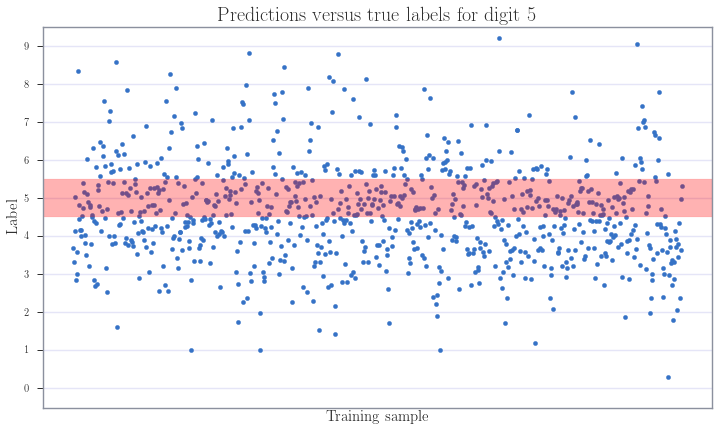

In [113]:
plt.figure(figsize=(12,7))
ax = plt.gca()
ax.set_axisbelow(True)
plt.grid(True)

plt.scatter(range(test_results_filtered.shape[0]), test_results_filtered[:,1], s=20)
#plt.errorbar(range(test_results_filtered.shape[0]), test_results_filtered[:,1], 
#             yerr=test_results_filtered[:,2]/1e13, fmt='.',)

ax.axhspan(ymin=test_results_filtered[0,0]-0.5, ymax=test_results_filtered[0,0]+0.5, color='red', alpha=0.3)

plt.xlabel('Training sample', fontsize=15)
plt.ylabel('Label', fontsize=15)
plt.title('Predictions versus true labels for digit 5', fontsize=20)
plt.ylim(-0.5, 9.5)
plt.yticks(range(0, 10, 1))
plt.xticks([])
plt.show()

This plot displays all the samples associated to label `5` and prediction of those samples (the red band represents the range $\pm$ $0.5$). Since this is a regression problem, we could use also the Mean Squared Error as figure of merit for analyzing the performances.

In [117]:
print('MeanSquaredError for MNIST: %.4f' % mean_squared_error(mnist_label_test, mnist_pred_mu))
print('MeanSquaredError for CIFAR: %.4f' % mean_squared_error(cifar10_label_test, cifar_pred_mu))

MeanSquaredError for MNIST: 2.4805
MeanSquaredError for CIFAR: 8.1734


## Label discretization

The most immediate way to perform label discretization is to look into ranges of values and associate for each of them a label. The next plot is the same as before but with label discretization.

In [118]:
test_results_filtered = list(filter(lambda x : x[0]==5, test_results))
test_results_filtered = np.array(test_results_filtered)

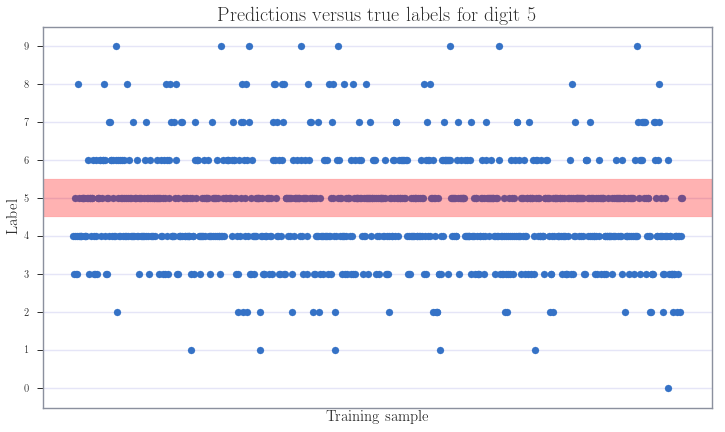

In [119]:
plt.figure(figsize=(12,7))
ax = plt.gca()
ax.set_axisbelow(True)

plt.grid(True)

plt.scatter(range(test_results_filtered.shape[0]), 
            discretizeLabels(test_results_filtered[:,1]), s=50)

ax.axhspan(ymin=test_results_filtered[0,0]-0.5, ymax=test_results_filtered[0,0]+0.5, color='red', alpha=0.3)

plt.xlabel('Training sample', fontsize=15)
plt.ylabel('Label', fontsize=15)
plt.title('Predictions versus true labels for digit 5', fontsize=20)
plt.ylim(-0.5, 9.5)
plt.yticks(range(10))
plt.xticks([])
plt.show()

Using this discretization strategy, let's see the the confusion matrix for both the datasets.

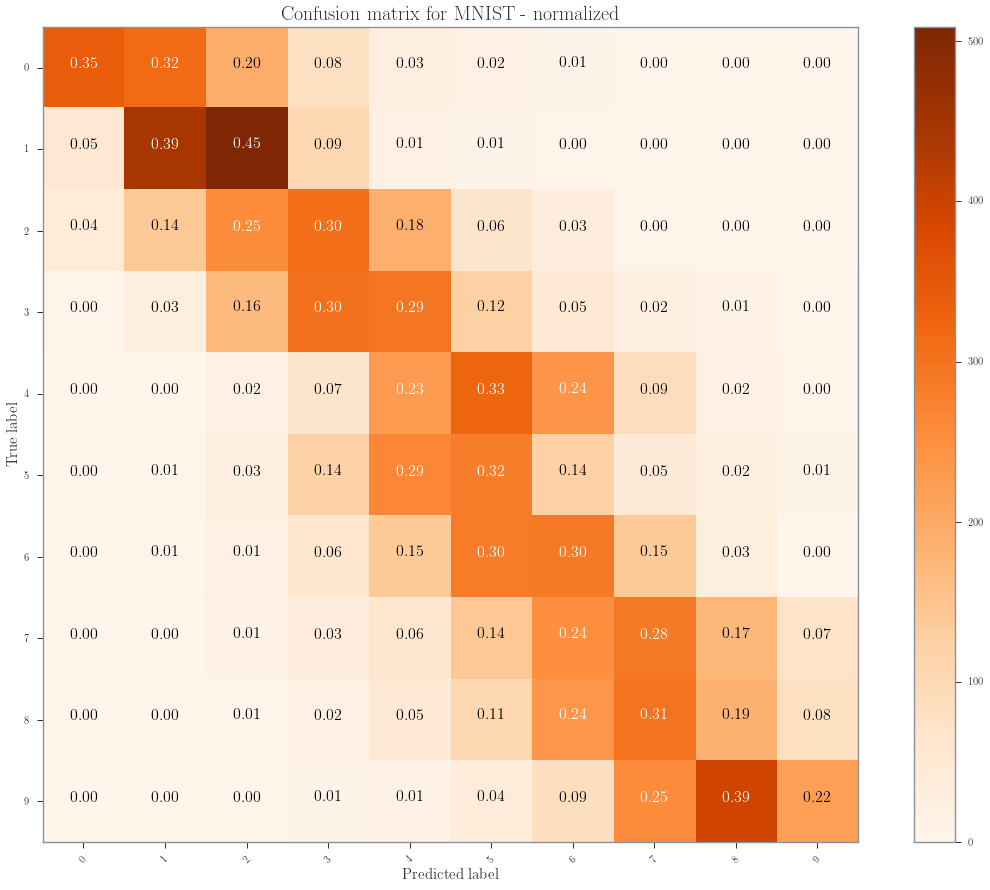

In [124]:
cm = confusion_matrix(y_true=mnist_label_test, y_pred=discretizeLabels(mnist_pred_mu))
plot_confusion_matrix(cm, range(10), title='Confusion matrix for MNIST', normalize=True)

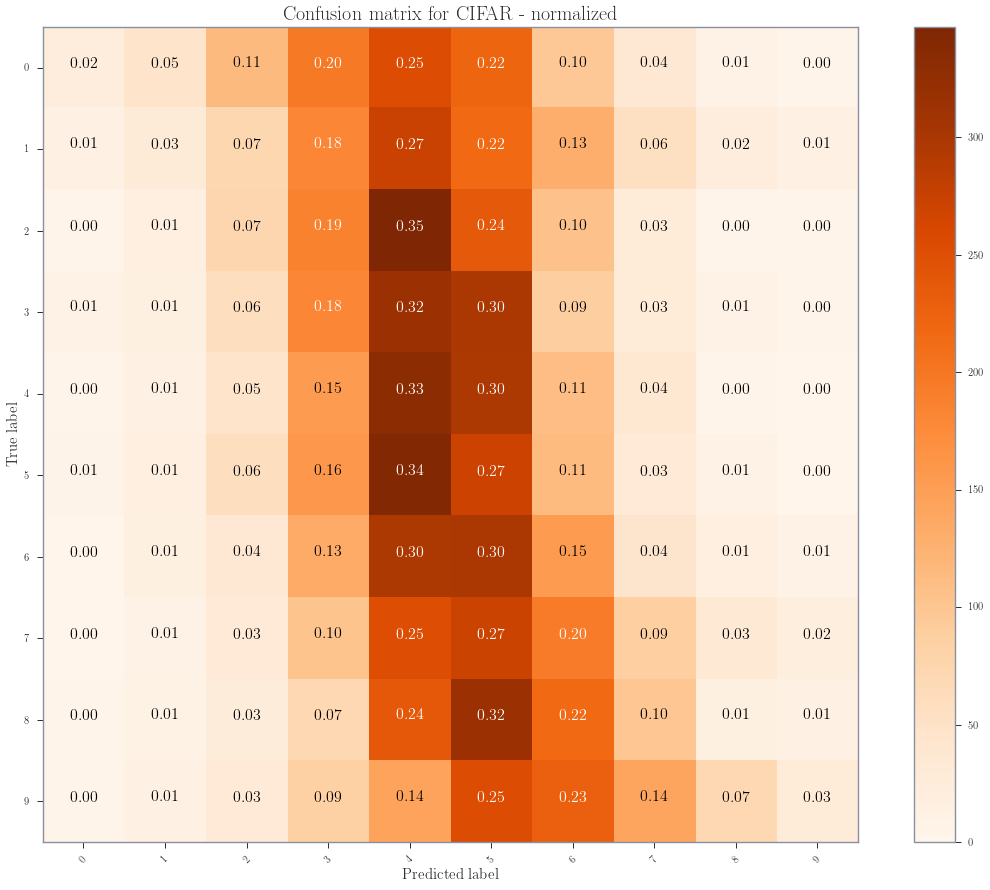

In [126]:
cm = confusion_matrix(y_true=cifar10_label_test, y_pred=discretizeLabels(cifar_pred_mu))
plot_confusion_matrix(cm, range(10), title='Confusion matrix for CIFAR', normalize=True)

## Discuss regression performance with respect to classification performance

TODO

## Describe one limitation of using regression for this particular task

TODO